# Analysis

In [32]:
import os
import sys
CURRENT_DIR = os.getcwd()
ROOT_DIR = os.path.abspath(os.path.join(CURRENT_DIR, os.pardir))
sys.path.append(ROOT_DIR)

from functools import partial

import numpy as np
from scipy.spatial import KDTree

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import matplotlib.pyplot as plt
from ipywidgets import HBox, Play, IntSlider, jslink, interactive_output

from utils import evs_load, video_load, plotFrame, plotPlayer

## Setup

In [33]:
# Matplotlib parameters
FIGSIZE_UNIT = 6
TINY_SIZE=16
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 26

plt.rc('font', family='Arial')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [34]:
target_dir = os.path.join(ROOT_DIR, 'output/sanmiguel_32spp')
img_width = 200
img_height = 200
num_frames = 240
t_max = 4.0

## Movie

In [35]:
refs_mov = video_load(os.path.join(target_dir, 'refs_evs.mp4'))
esim_mov = video_load(os.path.join(target_dir, 'esim_evs.mp4'))
alph_mov = video_load(os.path.join(target_dir, 'alph_evs.mp4'))
ours_mov = video_load(os.path.join(target_dir, 'ours_evs.mp4'))

In [36]:
def plotFrame(t):
    fig = plt.figure(figsize=(16, 4))

    ax = fig.add_subplot(141)
    ax.imshow(refs_mov[t], cmap='gray')
    ax.set_title('Reference')
    ax.axis('off')

    ax = fig.add_subplot(142)
    ax.imshow(esim_mov[t], cmap='gray')
    ax.set_title('ESIM')
    ax.axis('off')

    ax = fig.add_subplot(143)
    ax.imshow(alph_mov[t], cmap='gray')
    ax.set_title('WLR-ESIM')
    ax.axis('off')

    ax = fig.add_subplot(144)
    ax.imshow(ours_mov[t], cmap='gray')
    ax.set_title('D-ESIM (ours)')
    ax.axis('off')

    plt.tight_layout()
    plt.show()

def plotPlayer(plot, start, end, step=1):
    interval = (end - start + 1) // 2
    slider = IntSlider(min=start, max=end, step=1, continuous_update=True)
    play = Play(min=start, max=end, step=step, interval=interval, description="Movie")
    jslink((play, 'value'), (slider, 'value'))
    controller = HBox([play, slider])
    output = interactive_output(plot, {"t": slider})
    return display(controller, output)

plotPlayer(plotFrame, 0, len(esim_mov) - 1)

Output()

## Point-based metrics

In [37]:
ev_refs = evs_load(os.path.join(target_dir, 'refs_evs.raw'))
ev_esim = evs_load(os.path.join(target_dir, 'esim_evs.raw'))
ev_alph = evs_load(os.path.join(target_dir, 'alph_evs.raw'))
ev_ours = evs_load(os.path.join(target_dir, 'ours_evs.raw'))

ev_refs = np.array(ev_refs)
ev_esim = np.array(ev_esim)
ev_alph = np.array(ev_alph)
ev_ours = np.array(ev_ours)

print('refs: %d events' % (len(ev_refs)))
print('esim: %d events' % (len(ev_esim)))
print('alph: %d events' % (len(ev_alph)))
print('ours: %d events' % (len(ev_ours)))

refs: 959695 events
esim: 2237243 events
alph: 1054341 events
ours: 851030 events


### Plot events

In [38]:
def plot(ev, image_shape=None, t_max=None, title=''):
    if image_shape is None:
        width = ev[:, 0].max()
        height = ev[:, 1].max()
    else:
        width, height = image_shape

    if t_max is None:
        t_max = ev[:, 2].max()

    xs_pos, ys_pos, ts_pos, _ = np.transpose(np.array(ev[ev[:, 3] > 0]), axes=(1, 0))
    xs_neg, ys_neg, ts_neg, _ = np.transpose(np.array(ev[ev[:, 3] < 0]), axes=(1, 0))
    ys_pos = height - ys_pos - 1
    ys_neg = height - ys_neg - 1

    fig = plt.figure(figsize=(16, 9), dpi=100)
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.scatter(ts_pos, xs_pos, ys_pos, alpha=0.4, s=1, color='tab:red', label='positive')
    ax.scatter(ts_neg, xs_neg, ys_neg, alpha=0.4, s=1, color='tab:blue', label='negative')
    ax.set_xlabel('t', labelpad=20)
    ax.set_ylabel('x', labelpad=10)
    ax.set_zlabel('y', labelpad=10)
    ax.set_yticks(np.arange(0, width + 1, 50))
    ax.set_zticks(np.arange(0, height + 1, 50))
    ax.set_xlim([0, t_max])
    ax.set_ylim([0, width])
    ax.set_zlim([0, height])
    ax.set_box_aspect((2, 1, 1))
    leg = ax.legend()
    leg.legendHandles[0]._sizes = [30]
    leg.legendHandles[1]._sizes = [30]
    plt.show()


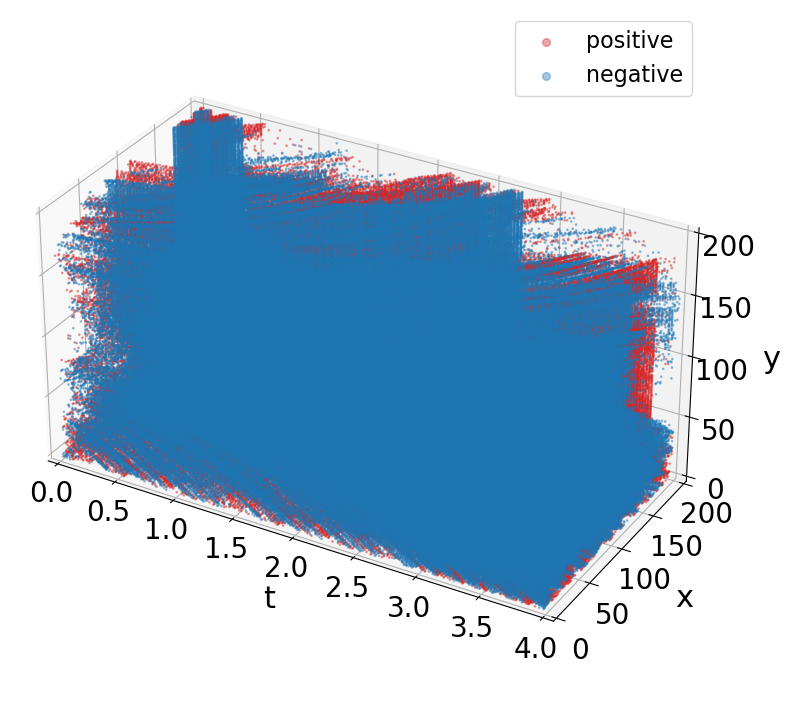

In [39]:
plot(ev_refs, image_shape=(img_width, img_height), t_max=t_max)

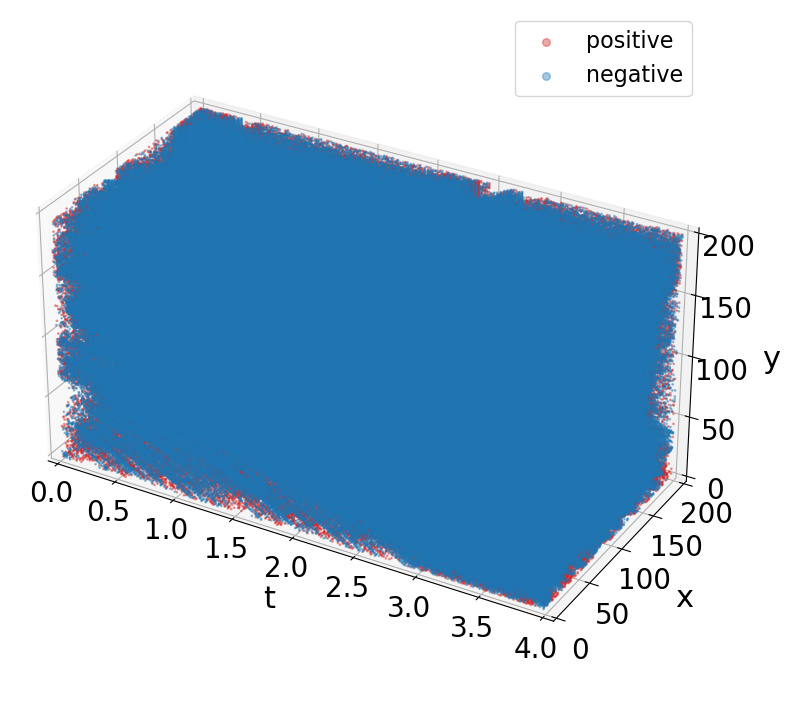

In [40]:
plot(ev_esim, image_shape=(img_width, img_height), t_max=t_max)

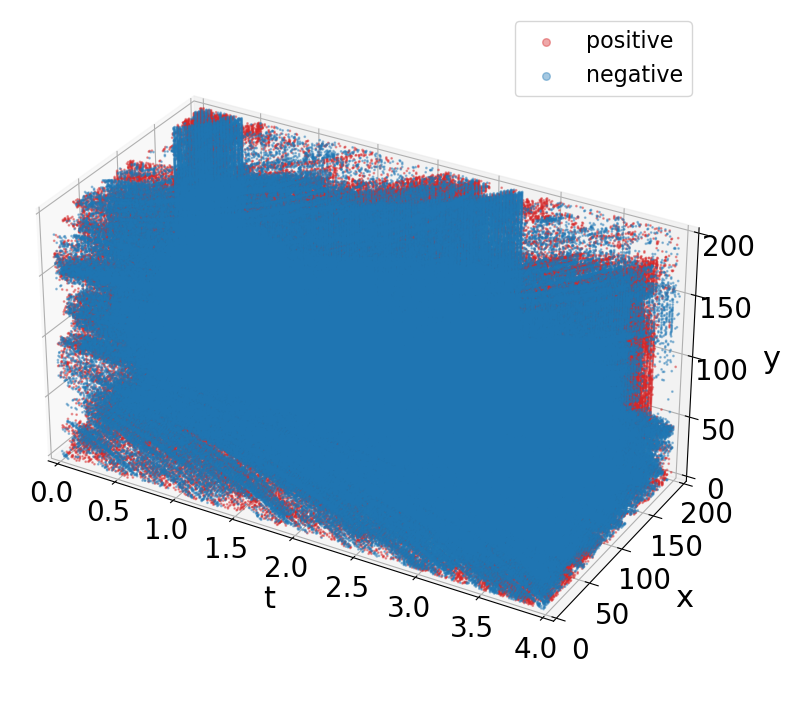

In [41]:
plot(ev_alph, image_shape=(img_width, img_height), t_max=t_max)

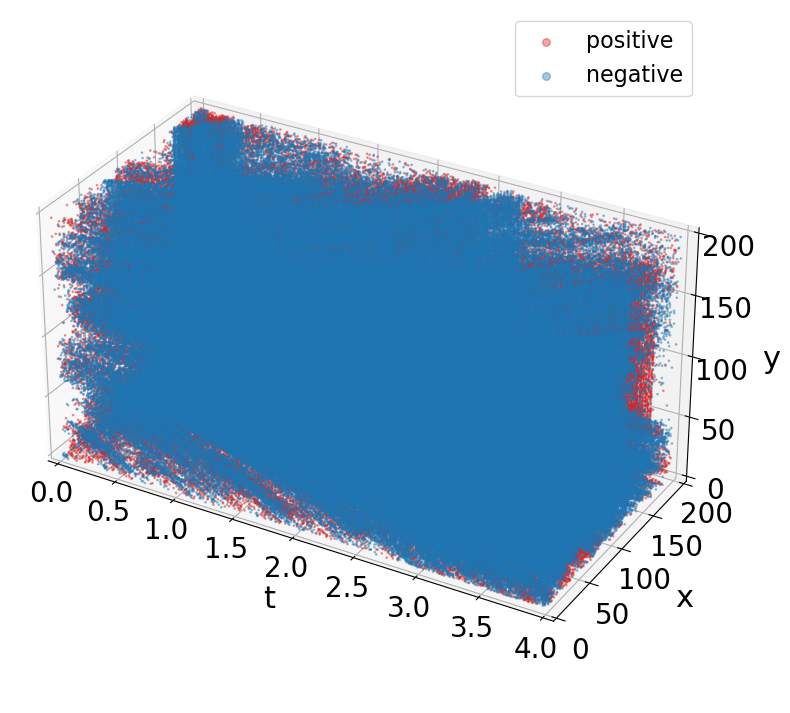

In [42]:
plot(ev_ours, image_shape=(img_width, img_height), t_max=t_max)

### Precision, Recall, F1 score, and FMI

In [43]:
def nearest(src, dst):
    s = src.copy()
    t = dst.copy()
    s[:, 3] *= 1.0e20
    t[:, 3] *= 1.0e20
    kd = KDTree(t)
    idx = kd.query(s, k=1)[1]
    s = s[:, :3]
    t = t[:, :3]
    return np.sum(np.abs(s - t[idx]) ** 2.0, axis=1)

def chamfer_distance(p0, p1):
    """
    p0: [N, 4]
    p1: [M, 4]
    p0[i] = (x, y, t, p), i = 1, ..., N
    p1[j] = (x, y, t, p), j = 1, ..., M
    """
    d0 = nearest(p0, p1)
    d1 = nearest(p1, p0)
    return 0.5 * (np.mean(d0) + np.mean(d1))

In [44]:
xs, ys, ts, ps = np.transpose(ev_refs, axes=(1, 0))
ps_refs = np.stack([xs / img_width, ys / img_height, 1.0e10 * ts / t_max, ps], axis=1)
xs, ys, ts, ps = np.transpose(ev_esim, axes=(1, 0))
ps_esim = np.stack([xs / img_width, ys / img_height, 1.0e10 * ts / t_max, ps], axis=1)
xs, ys, ts, ps = np.transpose(ev_alph, axes=(1, 0))
ps_alph = np.stack([xs / img_width, ys / img_height, 1.0e10 * ts / t_max, ps], axis=1)
xs, ys, ts, ps = np.transpose(ev_ours, axes=(1, 0))
ps_ours = np.stack([xs / img_width, ys / img_height, 1.0e10 * ts / t_max, ps], axis=1)

In [45]:
cham_esim = chamfer_distance(ps_refs, ps_esim)
cham_alph = chamfer_distance(ps_refs, ps_alph)
cham_ours = chamfer_distance(ps_refs, ps_ours)

In [46]:
print('*** chamfer distances ***')
print('esim: %f' % (cham_esim))
print('alph: %f' % (cham_alph))
print('ours: %f' % (cham_ours))

*** chamfer distances ***
esim: 0.000448
alph: 0.000176
ours: 0.000198


In [47]:
rec_esim = nearest(ps_esim, ps_refs)
pre_esim = nearest(ps_refs, ps_esim)
rec_alph = nearest(ps_alph, ps_refs)
pre_alph = nearest(ps_refs, ps_alph)
rec_ours = nearest(ps_ours, ps_refs)
pre_ours = nearest(ps_refs, ps_ours)


In [48]:
max_dist = 0
max_dist = max(max_dist, np.max(pre_esim), np.max(rec_esim))
max_dist = max(max_dist, np.max(pre_alph), np.max(rec_alph))
max_dist = max(max_dist, np.max(pre_ours), np.max(rec_ours))
ds = np.linspace(0, max_dist * 0.1, 500)

In [49]:
def metrics(pre, rec, dists):
    ps = []
    rs = []
    fs = []
    fmis = []
    for d in dists:
        p = np.mean(pre < d)
        r = np.mean(rec < d)
        f = (2.0 * p * r) / (p + r + 1.0e-12)
        fmi = np.sqrt(p * r)
        ps.append(p)
        rs.append(r)
        fs.append(f)
        fmis.append(fmi)

    return ps, rs, fs, fmis

In [50]:
prs_esim, rcs_esim, f1s_esim, fmi_esim = metrics(pre_esim, rec_esim, ds)
prs_alph, rcs_alph, f1s_alph, fmi_alph = metrics(pre_alph, rec_alph, ds)
prs_ours, rcs_ours, f1s_ours, fmi_ours = metrics(pre_ours, rec_ours, ds)

In [51]:
def plot_metric(xs, ys_list, label_list, title='', xlabel='', ylabel='', filename=None):
    fig = plt.figure(figsize=(8, 5), dpi=200)
    ax = fig.add_subplot(111)
    edgecolors = ['tab:blue', 'tab:green', 'tab:orange']
    
    for ys, label, edgecolor in zip(ys_list, label_list, edgecolors):
        ax.plot(xs, ys, label=label, color=edgecolor)

    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_color('black')

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim([-0.0001,0.0051])
    ax.set_ylim([-0.02,1.02])

    ax.legend(frameon=True, framealpha=1, borderpad=1, edgecolor='#666', loc='lower right')
    ax.grid(color='#dedede')

    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(target_dir, filename+'.pdf'))
    plt.show()

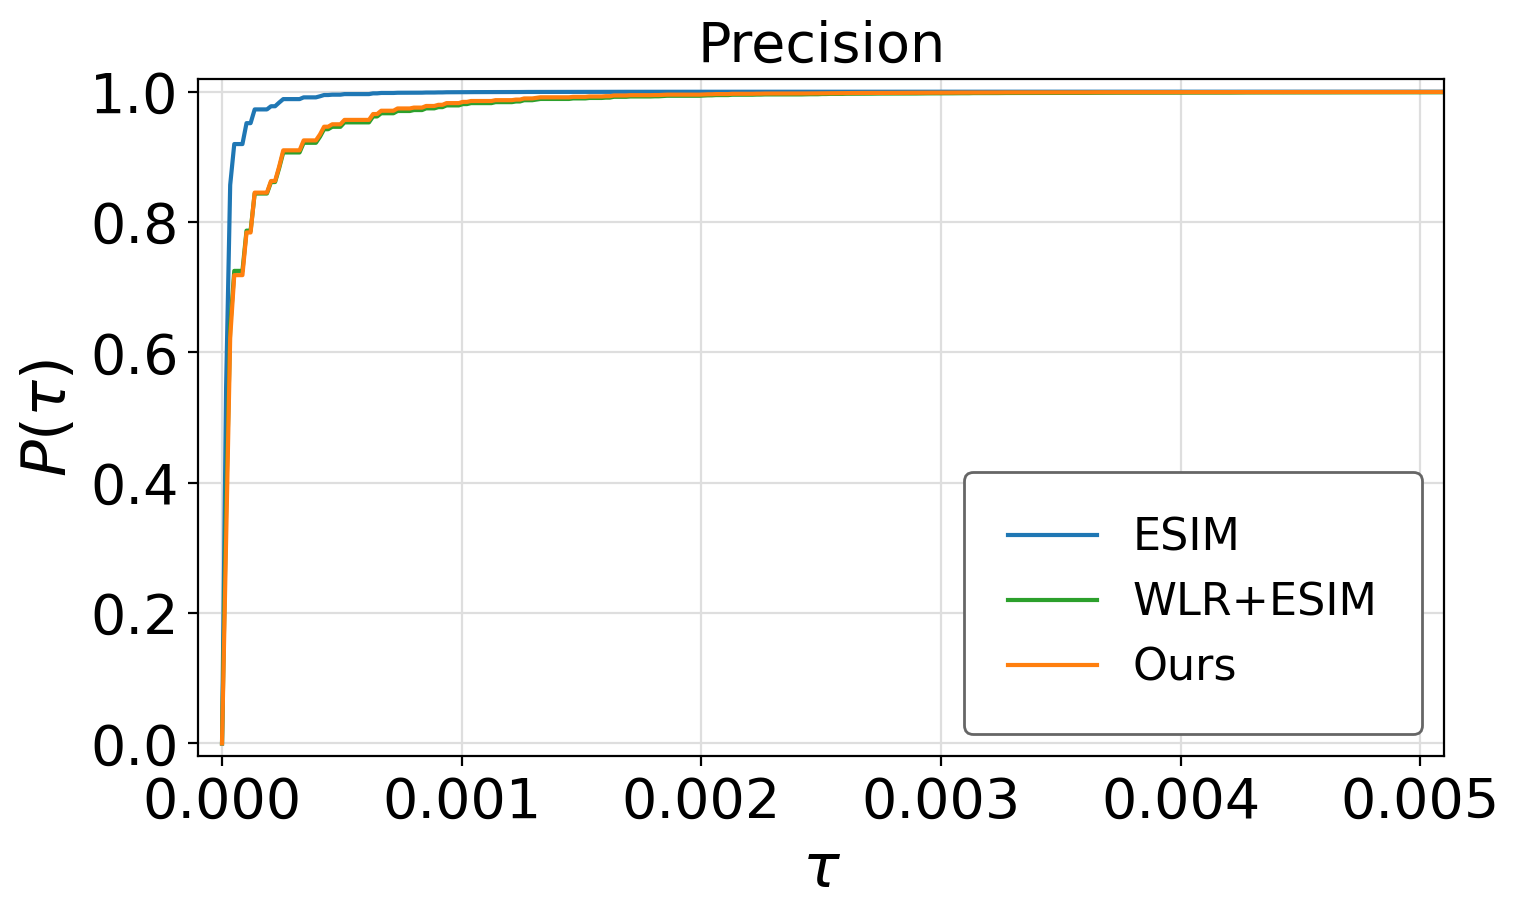

In [52]:
plot_metric(ds, [prs_esim, prs_alph, prs_ours], ['ESIM', 'WLR+ESIM', 'Ours'], title='Precision', xlabel='$\\tau$', ylabel='$P(\\tau)$', filename='precision')

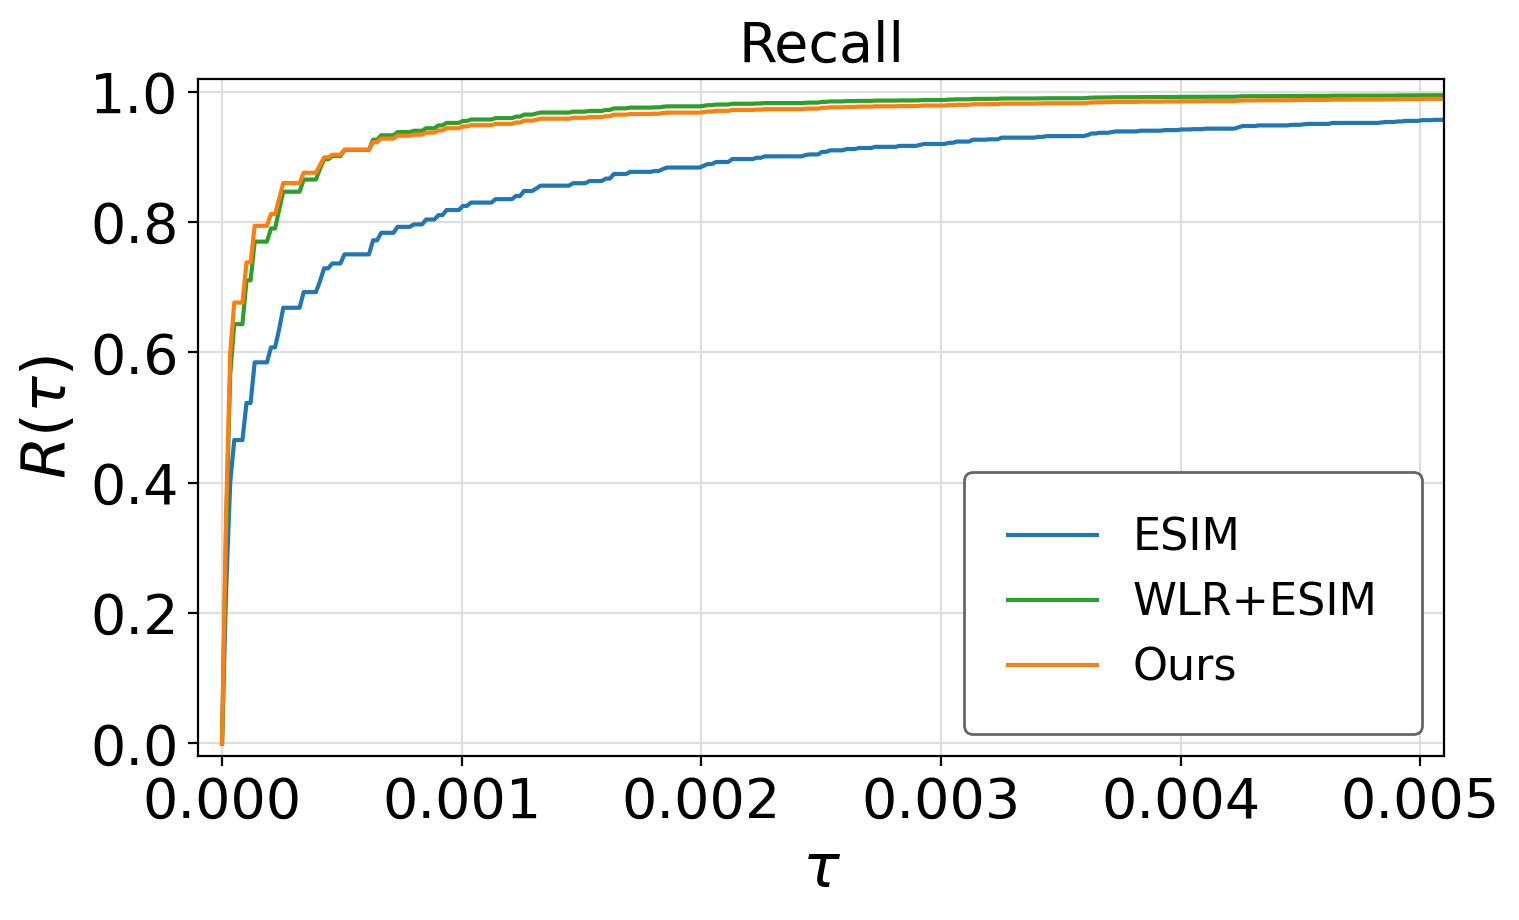

In [53]:

plot_metric(ds, [rcs_esim, rcs_alph, rcs_ours], ['ESIM', 'WLR+ESIM', 'Ours'], title='Recall', xlabel='$\\tau$', ylabel='$R(\\tau)$', filename='recall')

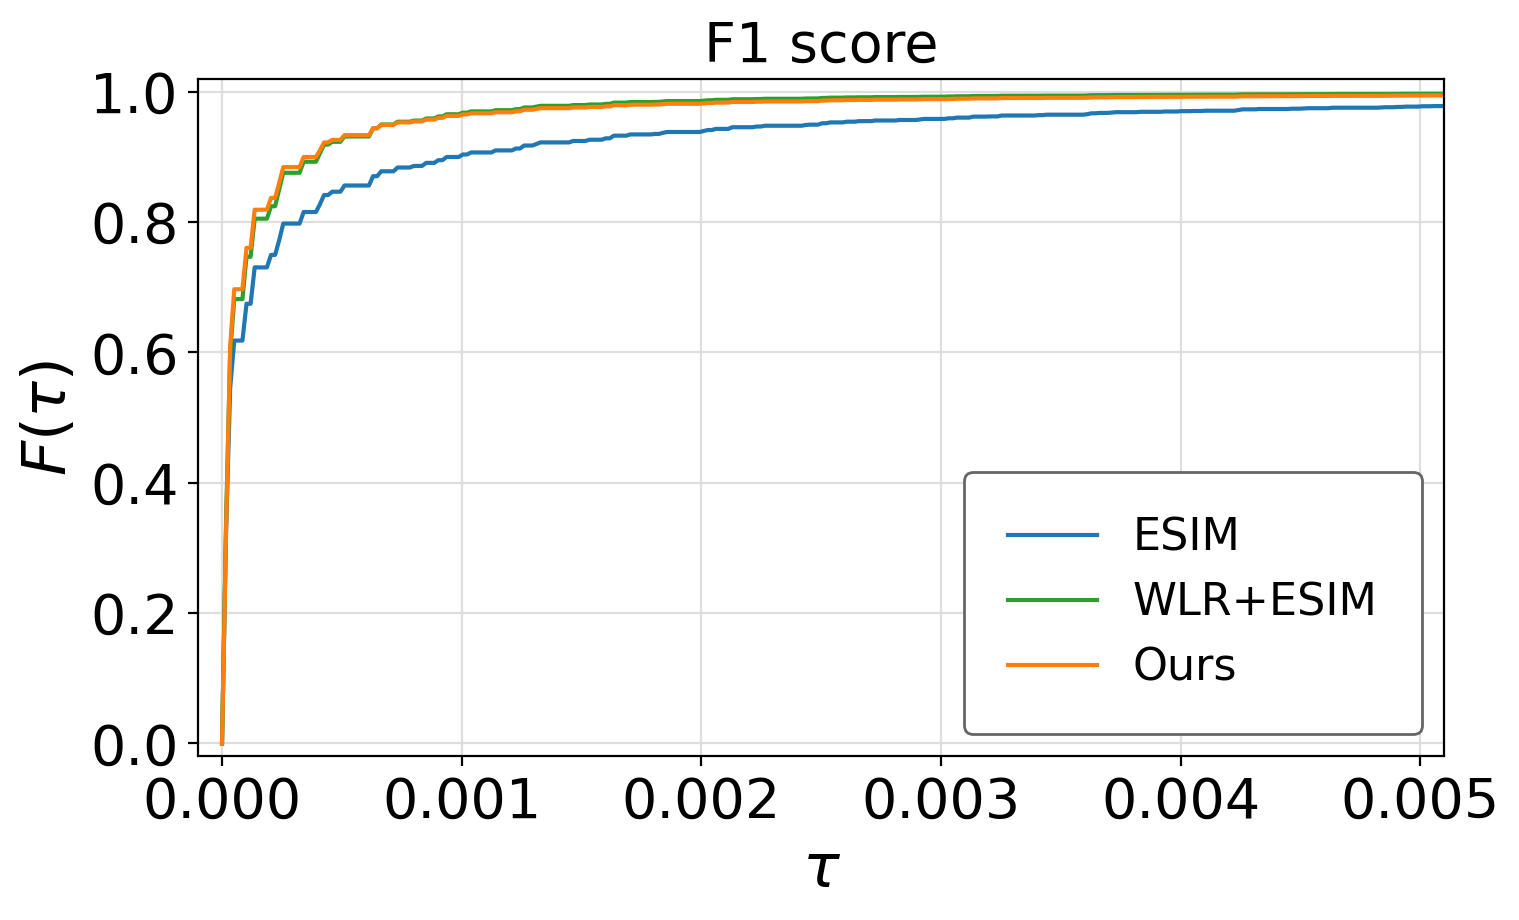

In [54]:

plot_metric(ds, [f1s_esim, f1s_alph, f1s_ours], ['ESIM', 'WLR+ESIM', 'Ours'], title='F1 score', xlabel='$\\tau$', ylabel='$F(\\tau)$', filename='f1score')

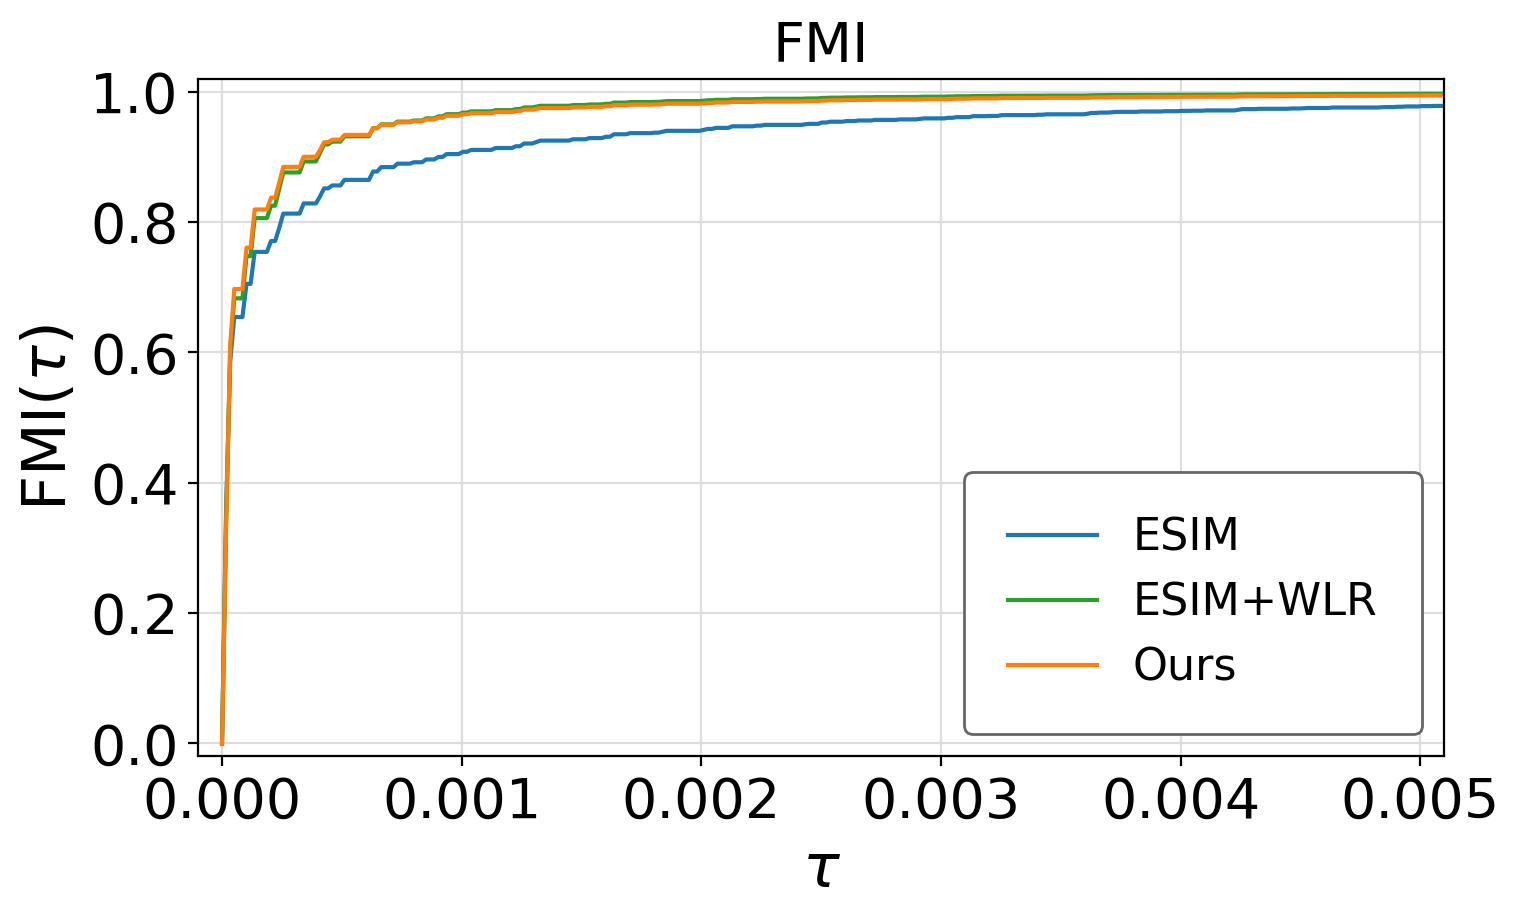

In [55]:
plot_metric(ds, [fmi_esim, fmi_alph, fmi_ours], ['ESIM', 'ESIM+WLR', 'Ours'], title='FMI', xlabel='$\\tau$', ylabel='FMI($\\tau$)', filename='fmi')

## Image-based metrics

In [56]:
refs_mov = np.load(os.path.join(target_dir, 'refs_evs.npy'))
esim_mov = np.load(os.path.join(target_dir, 'esim_evs.npy'))
alph_mov = np.load(os.path.join(target_dir, 'alph_evs.npy'))
ours_mov = np.load(os.path.join(target_dir, 'ours_evs.npy'))

In [57]:
rmse_esim = np.sqrt(np.mean((refs_mov - esim_mov) ** 2.0))
rmse_alph = np.sqrt(np.mean((refs_mov - alph_mov) ** 2.0))
rmse_ours = np.sqrt(np.mean((refs_mov - ours_mov) ** 2.0))

In [58]:
print('*** RMSE ***')
print('esim: {:.5f}'.format(rmse_esim))
print('alph: {:.5f}'.format(rmse_alph))
print('ours: {:.5f}'.format(rmse_ours))

*** RMSE ***
esim: 60.58625
alph: 47.47336
ours: 45.64028


In [59]:
psnr_esim = compare_psnr(refs_mov, esim_mov)
psnr_alph = compare_psnr(refs_mov, alph_mov)
psnr_ours = compare_psnr(refs_mov, ours_mov)

In [60]:
print('*** PSNR ***')
print('esim: {:.5f}'.format(psnr_esim))
print('alph: {:.5f}'.format(psnr_alph))
print('ours: {:.5f}'.format(psnr_ours))

*** PSNR ***
esim: 12.33393
alph: 14.46788
ours: 14.88900


In [61]:
def table1(idx, ys_list, label_list, title):
    print(title)
    for ys, label in zip(ys_list, label_list):
        print('  {}: {:.5f}'.format(label, ys[idx]))

In [62]:
thres = 0.0005

tau_idx = -1
for d in ds:
  if d > thres:
    break
  tau_idx +=1

print('tau_0 = {:.12f}'.format(ds[tau_idx]))
print('tau_1 = {:.12f}'.format(ds[tau_idx+1]))
table1(tau_idx, [prs_esim, prs_alph, prs_ours], ['esim', 'alph', 'ours'], title='Precision')
table1(tau_idx, [rcs_esim, rcs_alph, rcs_ours], ['esim', 'alph', 'ours'], title='Recall')
table1(tau_idx, [f1s_esim, f1s_alph, f1s_ours], ['esim', 'alph', 'ours'], title='F1 score')
table1(tau_idx, [fmi_esim, fmi_alph, fmi_ours], ['esim', 'alph', 'ours'], title='FMI')

tau_0 = 0.000493987976
tau_1 = 0.000511022044
Precision
  esim: 0.99543
  alph: 0.94615
  ours: 0.94999
Recall
  esim: 0.73640
  alph: 0.90121
  ours: 0.90332
F1 score
  esim: 0.84654
  alph: 0.92313
  ours: 0.92607
FMI
  esim: 0.85617
  alph: 0.92340
  ours: 0.92636
